# **Algorithmic Trading: German Electricity Market**

In [397]:
%load_ext autoreload
%autoreload 2

import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
from pykalman import KalmanFilter
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats.mstats import winsorize


random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [398]:
df = pd.read_csv("train.csv", index_col=["date"], parse_dates=True)
df.index.name = "Date"
df

,wind,solar,load,spread
Date,,,,
2020-01-01 00:00:00,6084.0,0.0,43915.0,38.40
2020-01-01 00:15:00,5739.0,0.0,43770.0,-105.93
2020-01-01 00:30:00,5774.0,0.0,43267.0,-1.48
2020-01-01 00:45:00,5804.0,0.0,42934.0,3.97
2020-01-01 01:00:00,5791.0,0.0,42718.0,100.09
...,...,...,...,...
2023-12-31 22:45:00,29922.0,2.0,41550.0,102.06
2023-12-31 23:00:00,29546.0,3.0,40733.0,35.24
2023-12-31 23:15:00,29204.0,3.0,39805.0,78.57


## **Exploratory Data Analysis (EDA)**

In [399]:
df.describe()

,wind,solar,load,spread
count,140157.000000,140157.000000,140157.000000,140157.000000
mean,11739.139900,5815.140564,54558.491235,0.889667
std,9542.520295,8990.140639,9315.313098,220.876249
min,91.000000,0.000000,30389.000000,-9271.590000
25%,4218.000000,1.000000,47053.000000,-61.510000
50%,8827.000000,103.000000,54506.000000,3.230000
75%,17058.000000,9260.000000,62236.000000,63.090000
max,48158.000000,41445.000000,77752.000000,15781.480000


In [400]:
df.isnull().sum()

wind      0
solar     0
load      0
spread    0
dtype: int64

In [403]:
plot_configs = {
    "wind": {
        "title": "German day-ahead wind power forecast (MW)", 
        "label": "Wind Forecast", 
        "color": "blue", 
        "ylabel": "Megawatt (MW)"
    },
    "solar": {
        "title": "German day-ahead solar power forecast (MW)", 
        "label": "Solar Forecast", 
        "color": "orange", 
        "ylabel": "Megawatt (MW)"
    },
    "load": {
        "title": "German day-ahead load forecast (MW)", 
        "label": "Load Forecast", 
        "color": "green", 
        "ylabel": "Megawatt (MW)"
    },
    "spread": {
        "title": "Difference between Imbalances and Day-Ahead price (€)", 
        "label": "Price Spread", 
        "color": "red",  
        "ylabel": "Euro (€)"
    }
}


def plot_all(df, plot_configs):
    wind_data = df["wind"].values
    kf = KalmanFilter(
        initial_state_mean=wind_data[0],
        transition_matrices=[1],  # Random walk
        observation_matrices=[1],
        transition_covariance=1e-3,  # Small process noise
        observation_covariance=1e2   # Large observation noise
    )
    state_means_smooth, _ = kf.smooth(wind_data)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.tight_layout(h_pad=5, w_pad=4)
    axes = axes.flatten()

    for idx, (col, config) in enumerate(plot_configs.items()):
        axes[idx].plot(df.index, df[col], label=config["label"], color=config["color"])
        if col == "wind":
            axes[idx].plot(df.index, state_means_smooth, label="Kalman Smoother", color="red", linewidth=2)
        axes[idx].set_ylabel(config["ylabel"])
        axes[idx].set_xlabel("Date")
        axes[idx].set_title(config["title"])
        axes[idx].legend()
        axes[idx].grid(True)

    plt.show()


def plot_day(df, plot_configs, date=None):
    """
    Plots a specific day's data for all columns in a 2x2 grid using plot_configs.
    
    Args:
        df (pd.DataFrame): The data containing time series for multiple features.
        date (str): The date to plot (format: "YYYY-MM-DD").
        plot_configs (dict): Dictionary containing plot configurations for each column.
    """

    if date is None:
        unique_days = df.index.date
        date = random.choice(unique_days)
        day_data = df[df.index.date == date]
    else:
        day_data = df.loc[date]
    
    if day_data.empty:
        print(f"No data available for the selected date: {date}")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"German Energy Forecasts for {date}", fontsize=16, fontweight='bold', y=0.95)
    axes = axes.flatten()

    for idx, (col, config) in enumerate(plot_configs.items()):
        axes[idx].plot(day_data.index, day_data[col], label=config["label"], color=config["color"])
        if col == "spread":
            axes[idx].axhline(day_data["spread"].mean(), color="blue", linestyle='--', label="Average spread")
        axes[idx].set_ylabel(config["ylabel"])
        axes[idx].set_xlabel("Time")
        axes[idx].set_title(config["title"])
        axes[idx].legend()
        axes[idx].grid(True)

        axes[idx].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        axes[idx].xaxis.set_major_locator(mdates.HourLocator(interval=4))
        plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=0)

    plt.show()


def plot_week(df, plot_configs, start_date=None):
    """
    Plots a full week's data (Monday to Sunday) for all columns in a 2x2 grid using plot_configs.

    Args:
        df (pd.DataFrame): The data containing time series for multiple features.
        start_date (str): A date within the desired week (format: "YYYY-MM-DD"). If None, a random Monday is chosen.
        plot_configs (dict): Dictionary containing plot configurations for each column.
    """
    if start_date is None:
        unique_days = pd.to_datetime(df.index.date)
        mondays = unique_days[unique_days.weekday == 0]
        if len(mondays) == 0:
            print("No Mondays found in the dataset.")
            return
        start_date = random.choice(mondays)
    else:
        start_date = pd.to_datetime(start_date)
        if start_date.weekday != 0:
            start_date = start_date - pd.Timedelta(days=start_date.weekday())  # Adjust to previous Monday

    # Calculate the end of the week (Sunday)
    end_date = start_date + pd.Timedelta(days=6)
    week_data = df.loc[start_date:end_date]

    if week_data.empty:
        print(f"No data available for the week starting on: {start_date.date()}")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f"Week: {start_date.date()} to {end_date.date()}", fontsize=16, y=1.02)
    fig.tight_layout(h_pad=6, w_pad=4)
    axes = axes.flatten()

    for idx, (col, config) in enumerate(plot_configs.items()):
        axes[idx].plot(week_data.index, week_data[col], label=config["label"], color=config["color"])
        if col == "spread":
            axes[idx].axhline(week_data["spread"].mean(), color="blue", linestyle='--', label="Average spread")
        axes[idx].set_ylabel(config["ylabel"])
        axes[idx].set_xlabel("Day")
        axes[idx].set_title(config["title"], fontsize=14, fontweight="bold")
        axes[idx].legend()
        axes[idx].grid(True)

        axes[idx].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
        axes[idx].xaxis.set_major_locator(mdates.DayLocator())
        plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45)

    plt.show()

### **Time Series Evolutions**

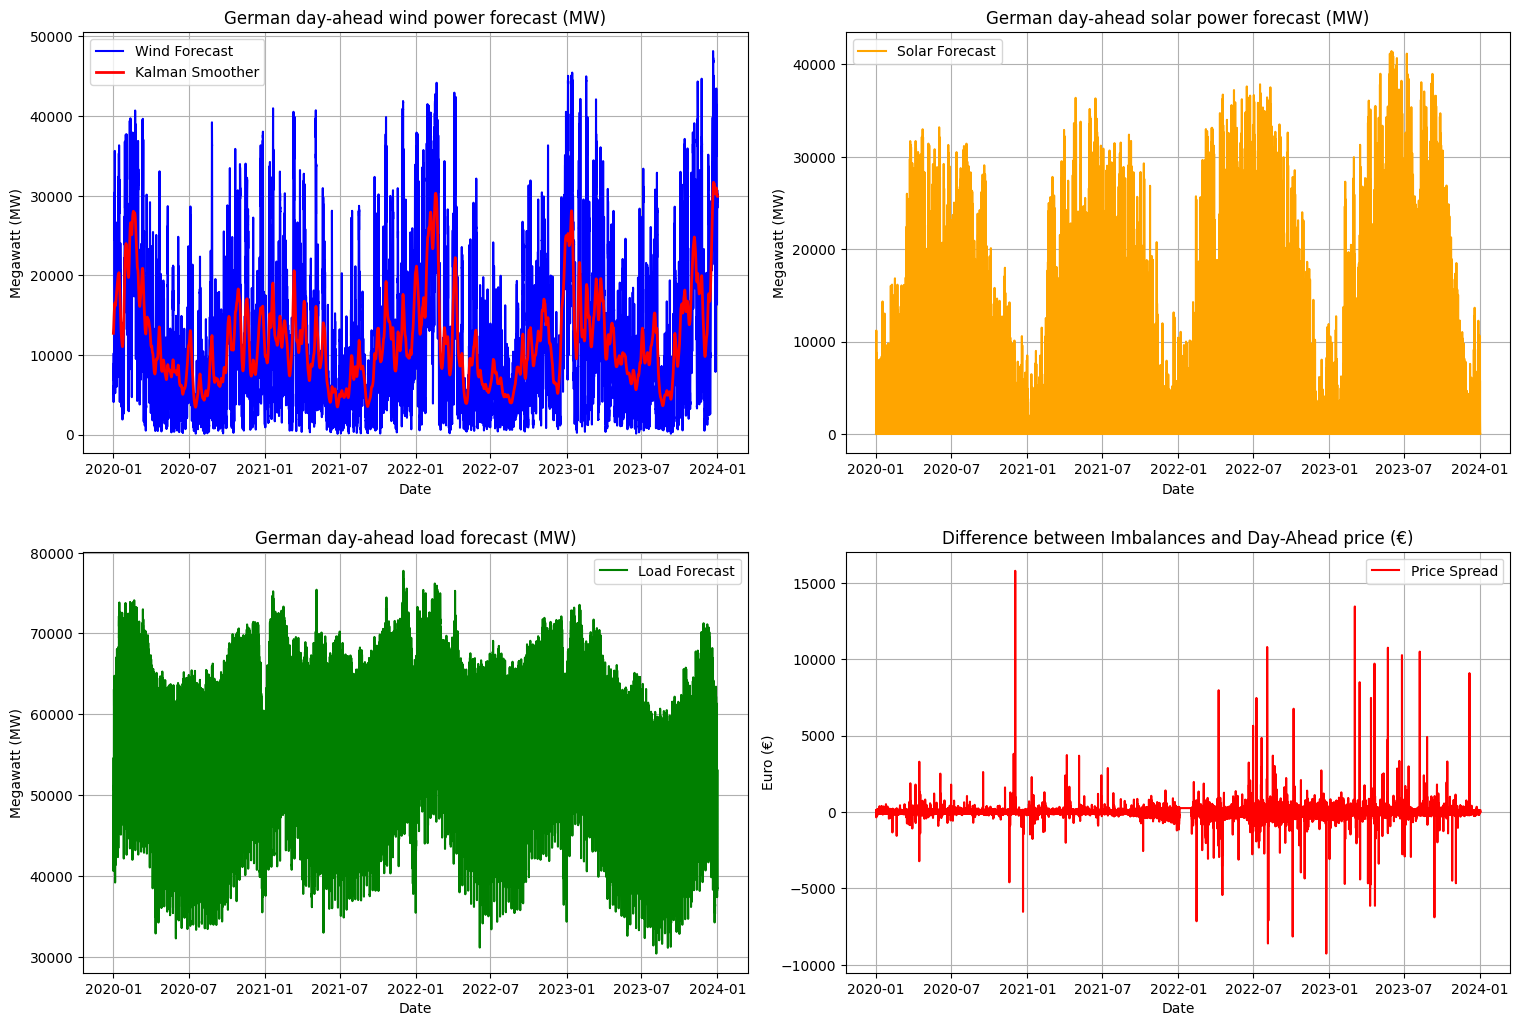

In [404]:
plot_all(df, plot_configs)

- **Wind Power Forecasts (Top Left):** Wind power forecasts demonstrate some yearly seasonal patterns, with reduced wind activity typically observed during the summer months and increased wind levels during winter. 

- **Solar Power Forecasts (Top Right):** Solar power forecasts exhibit a well-defined yearly seasonality, with the lowest levels occurring consistently between December and February. This pattern aligns with reduced daylight hours during winter, providing a predictable trend that is easier to model compared to wind power.

- **Load Forecasts (Bottom Left):** Load forecasts indicate moderate yearly seasonality, with higher demand generally observed from autumn to winter, driven by increased heating needs. Notably, there is a significant dip in late December, likely attributable to reduced economic activity during the Christmas holidays.

- **Spread Between Imbalance and Day-Ahead Prices (Bottom Right):** The spread reveals a marked increase in volatility post-2022 compared to earlier periods. The source of this heightened volatility is not immediately apparent from the data, suggesting the need for further analysis, such as investigating its relationship with the wind, solar, and load forecasts to uncover potential drivers or correlations.

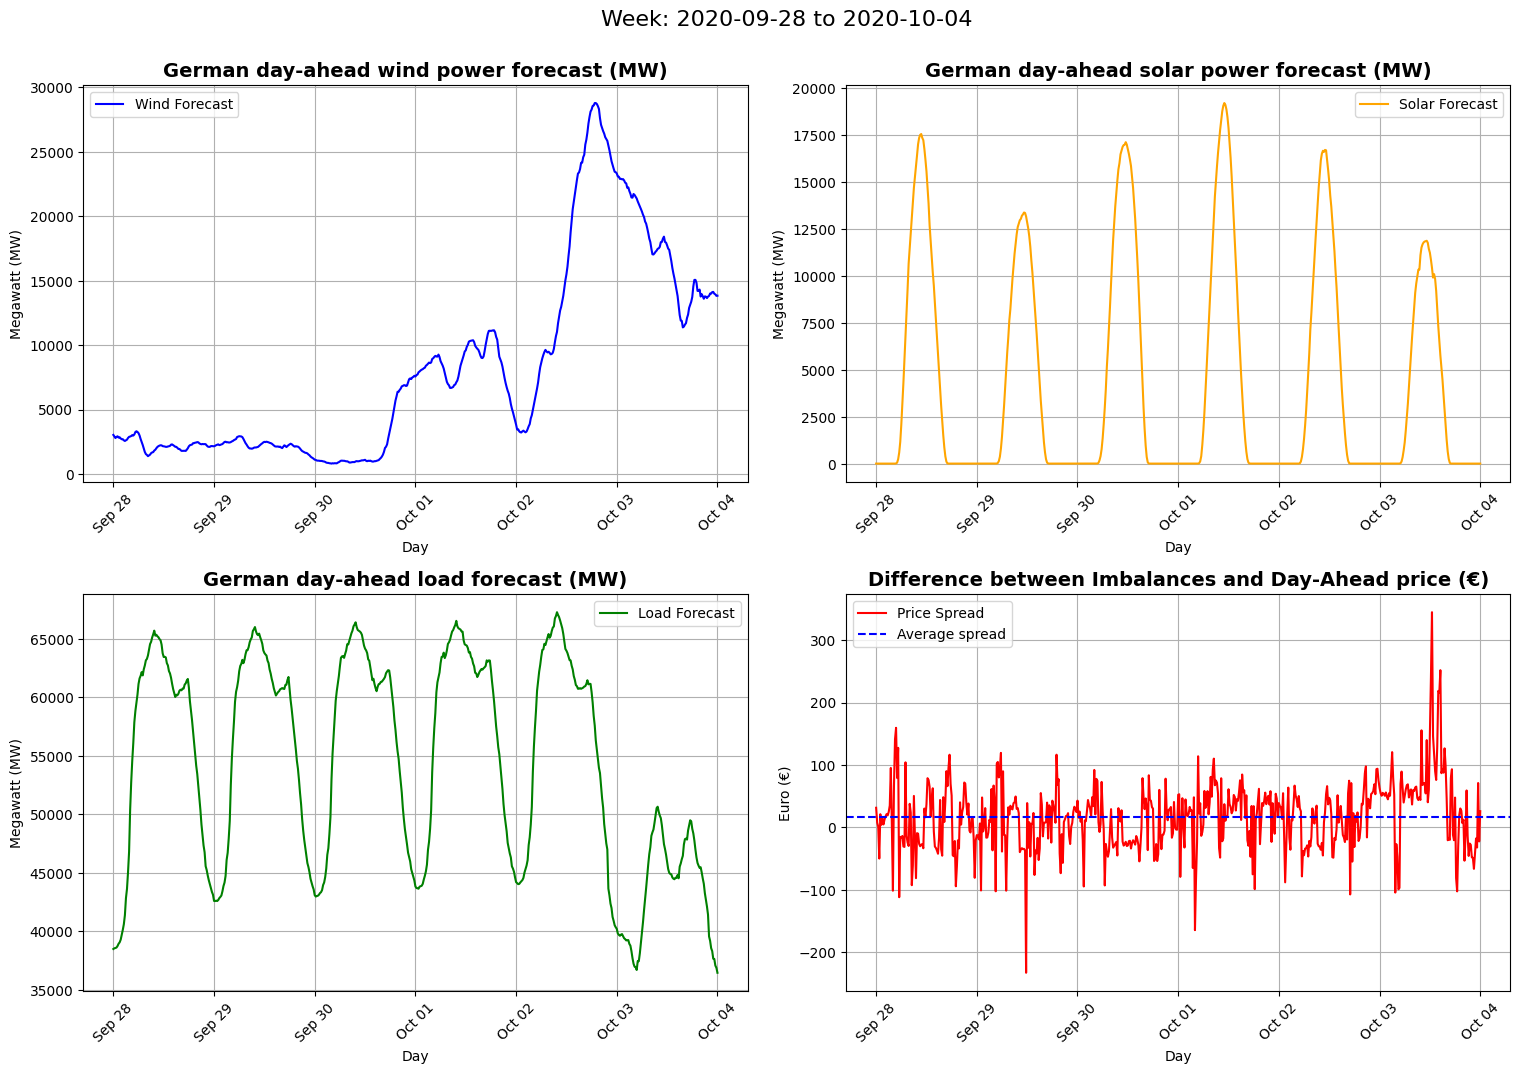

In [405]:
random.seed(42)
plot_week(df, plot_configs)

- Throughout the day, wind power forecasts exhibit smoother patterns, while solar forecasts show a clear peak around noon, following a near-normal distribution. In contrast, load forecasts and the spread are significantly more volatile. The spread appears to mean-revert around zero, which is expected given its nature as a derived metric balancing supply and demand fluctuations.

- There are notable spikes in the price spread on October 3rd and 4th, which are somewhat challenging to interpret. During this period, wind power forecasts remain relatively high compared to earlier days in the week (indicating high supply), while the load forecast reaches its lowest levels of the week (indicating low demand). At the same time, solar power forecasts are at minimal levels, contributing to reduced supply.

### **Seasonality Analysis**

With 15-min data, one day is 96 observations (96x15 = 1440 min = 24 hours) and one week is 672 (96x7)

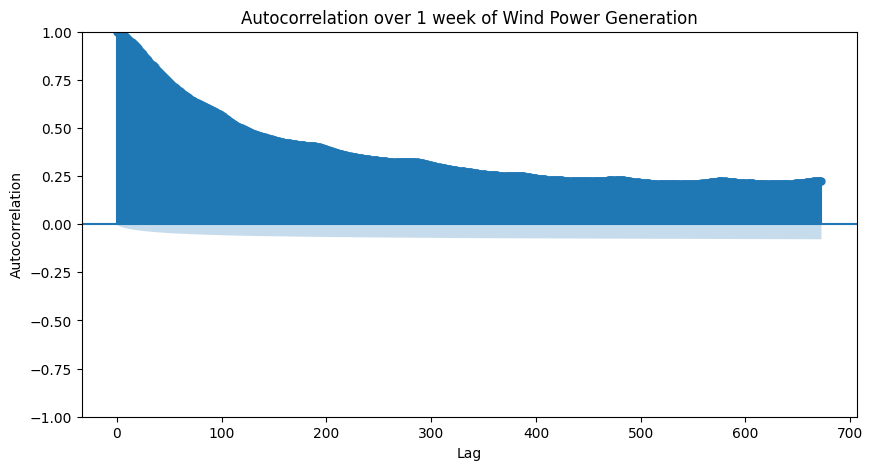

In [406]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df["wind"], lags=672, ax=ax, title="Autocorrelation over 1 week of Wind Power Generation")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
plt.show()

For wind generation, there is a high level autocorrelation intraday, after one day it is approx 65% and after one week it is approx 25%.

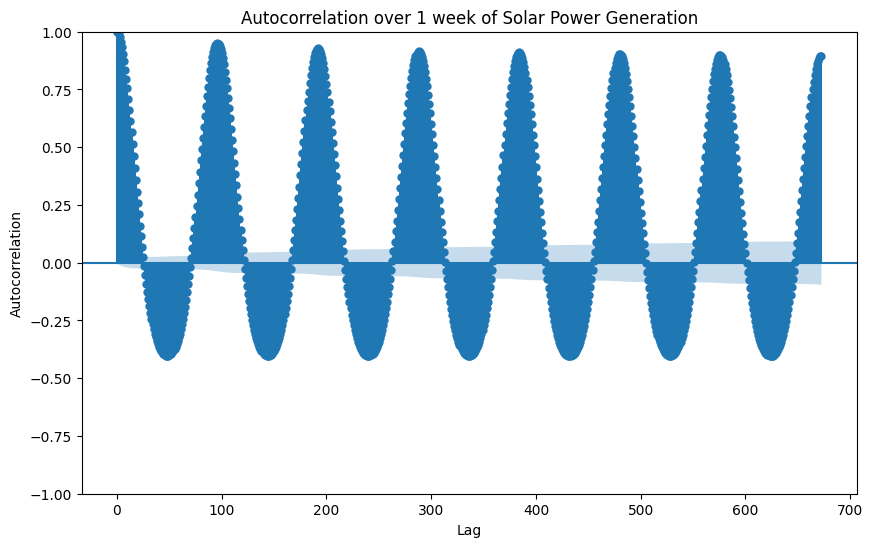

In [407]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(df["solar"], lags=672, ax=ax, title="Autocorrelation over 1 week of Solar Power Generation")
ax.set_xlabel("Lag")
ax.set_ylabel("Autocorrelation")
plt.show()

Compared to wind power, solar displays a strong daily seasonailiy where at every multiple of 96 lags we observe a spike in autocorrelation. This phenomena makes sense sun rises everyday over the course of the week at the same time and with approximately the same intensity.

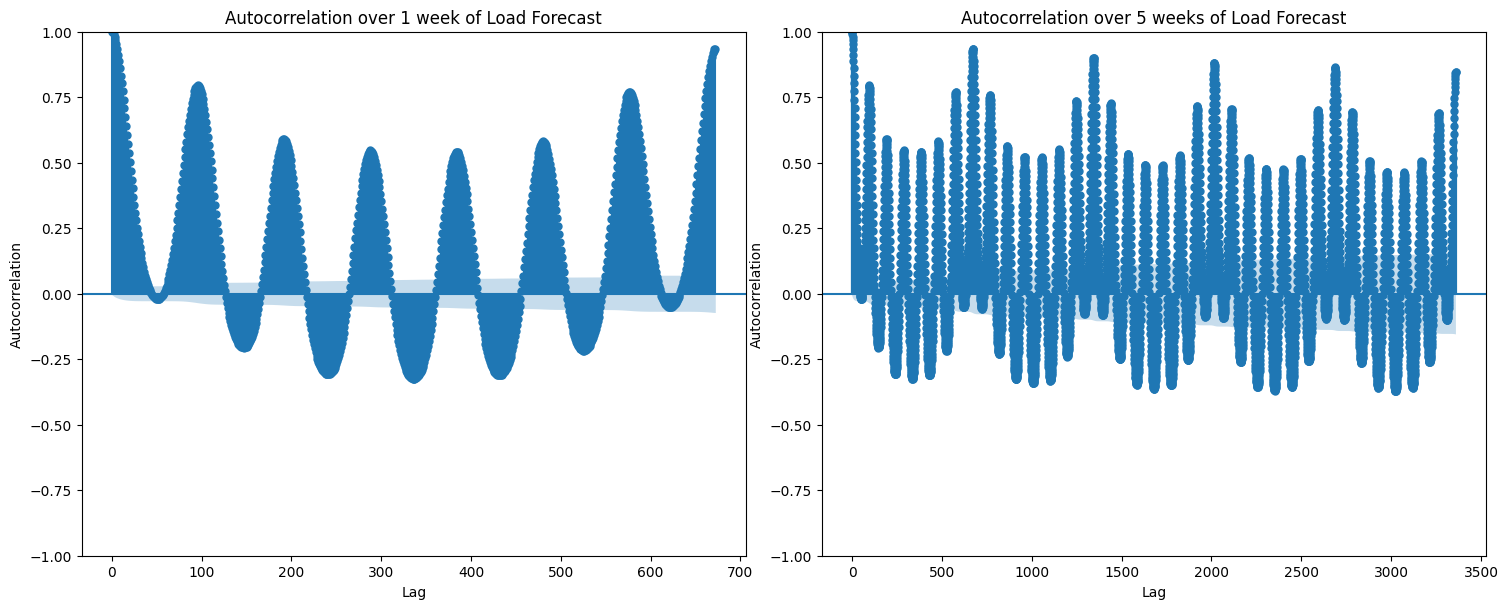

In [408]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_acf(df["load"], lags=672, ax=axes[0], title="Autocorrelation over 1 week of Load Forecast")
plot_acf(df["load"], lags=3360, ax=axes[1], title="Autocorrelation over 5 weeks of Load Forecast")
fig.tight_layout()
axes[0].set_xlabel("Lag")
axes[1].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")
axes[1].set_ylabel("Autocorrelation")
plt.xlabel("Lag")
plt.show()

For load, there is both a daily and a weekly seasonality where multiples of 672 display very high autocorrelation levels, indicating a weekly seasonality 

### **Distribution Analysis & Outliers Detection**

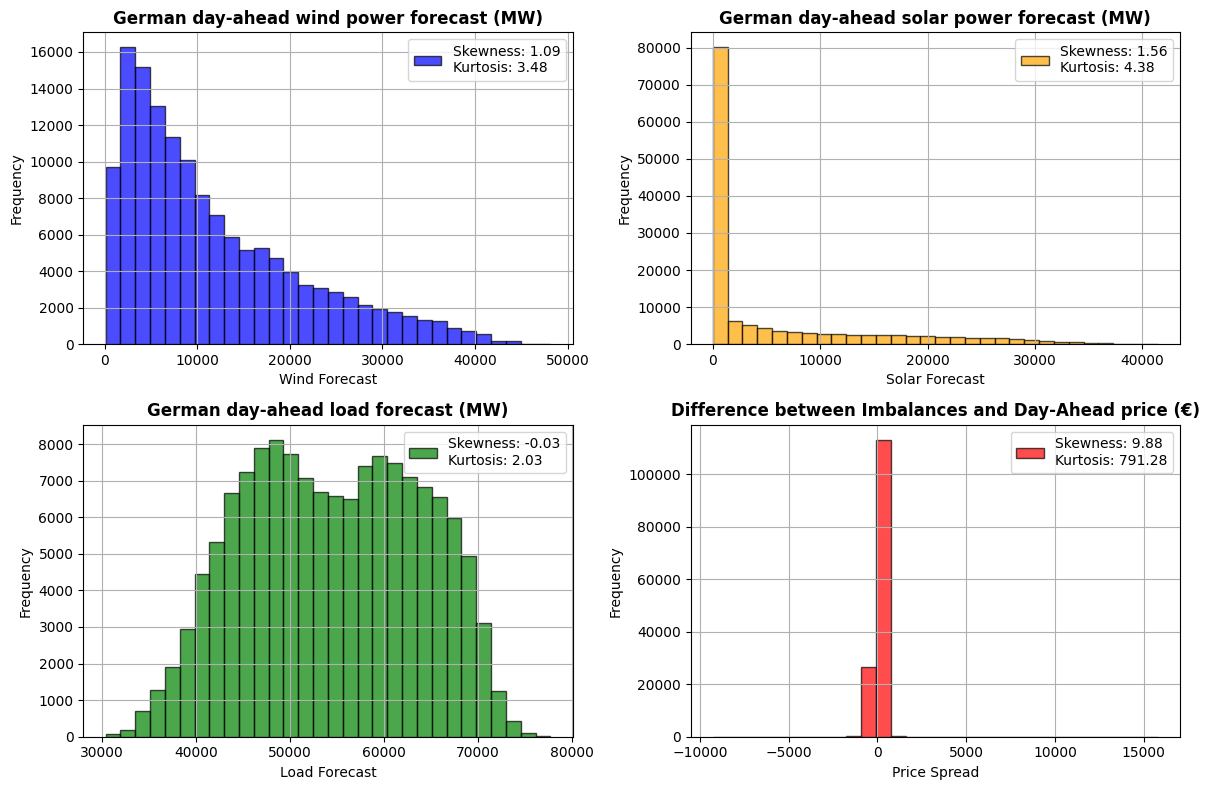

In [409]:
import scipy.stats as stats

def plot_histograms(df, plot_configs, bins=30, figsize=(12, 8)):
    """
    Plots histograms for up to 4 columns in a 2x2 grid with unique colors,
    displaying skewness and kurtosis as a legend for each plot.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        plot_configs (dict): Plot configuration dictionary for each column.
        bins (int): Number of bins for the histograms.
        figsize (tuple): Size of the figure.
    """
    cols = df.columns
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()  

    for idx, col in enumerate(cols):
        # Calculate skewness and kurtosis
        skewness = stats.skew(df[col].dropna())
        kurtosis = stats.kurtosis(df[col].dropna(), fisher=False)

        # Plot histogram
        axes[idx].hist(df[col].dropna(), bins=bins, color=plot_configs[col]["color"], alpha=0.7, edgecolor="black")
        axes[idx].set_title(plot_configs[col]["title"], fontsize=12, fontweight="bold")
        axes[idx].set_xlabel(plot_configs[col]["label"])
        axes[idx].set_ylabel("Frequency")
        axes[idx].grid(True)

        # Add skewness and kurtosis to the legend
        axes[idx].legend([f"Skewness: {skewness:.2f}\nKurtosis: {kurtosis:.2f}"], loc="upper right", fontsize=10)

    for idx in range(len(cols), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

plot_histograms(df, plot_configs)

- **Wind Power Forecast (Top Left)**: The distribution is positively skewed, with most values concentrated at lower power levels and a long tail of occasional high wind forecasts, reflecting the variability of wind generation.

- **Solar Power Forecast (Top Right)**: A heavily right-skewed distribution, with most values near zero, indicates low generation during nighttime or cloudy periods, with peaks corresponding to sunny conditions.

- **Load Forecast (Bottom Left)**: The nearly symmetric, bimodal distribution reflects varying energy consumption patterns, likely driven by differences between weekdays and weekends or daily demand cycles.

- **Spread Between Imbalance and Day-Ahead Prices (Bottom Right)**: The distribution is centered tightly around zero, suggesting close alignment between the two prices, with occasional outliers indicating market anomalies.

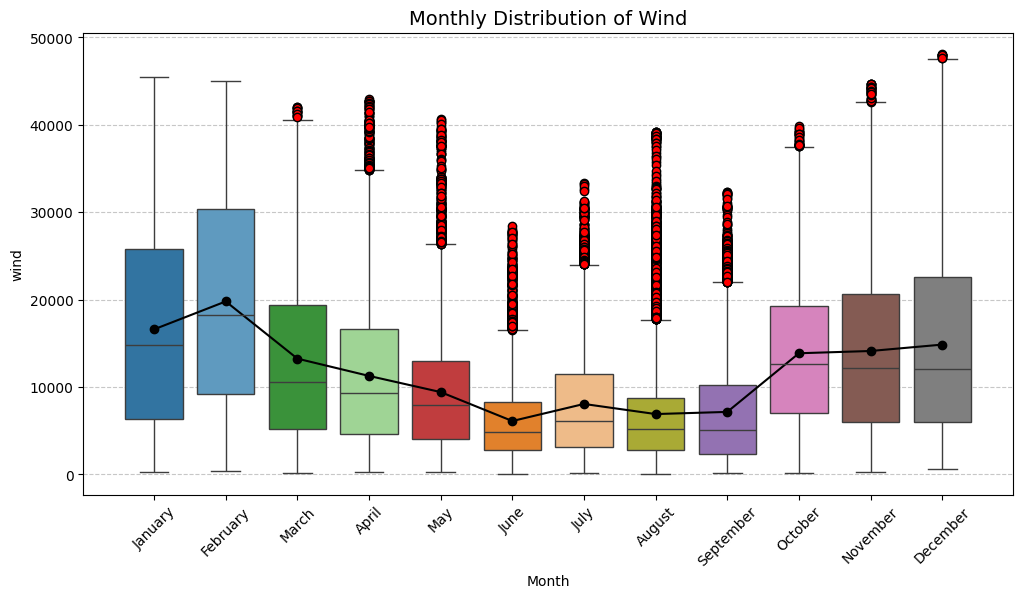

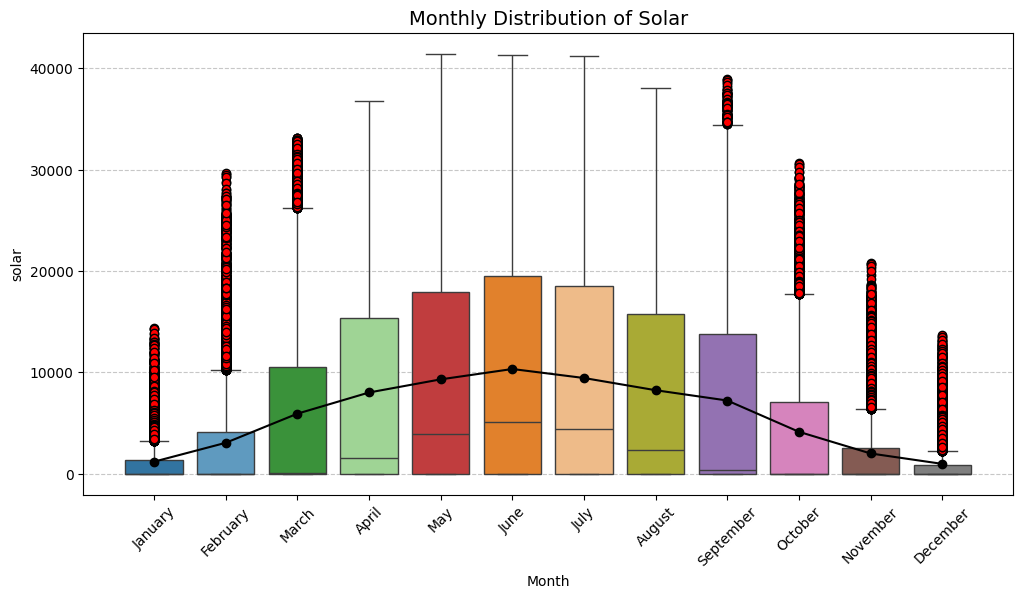

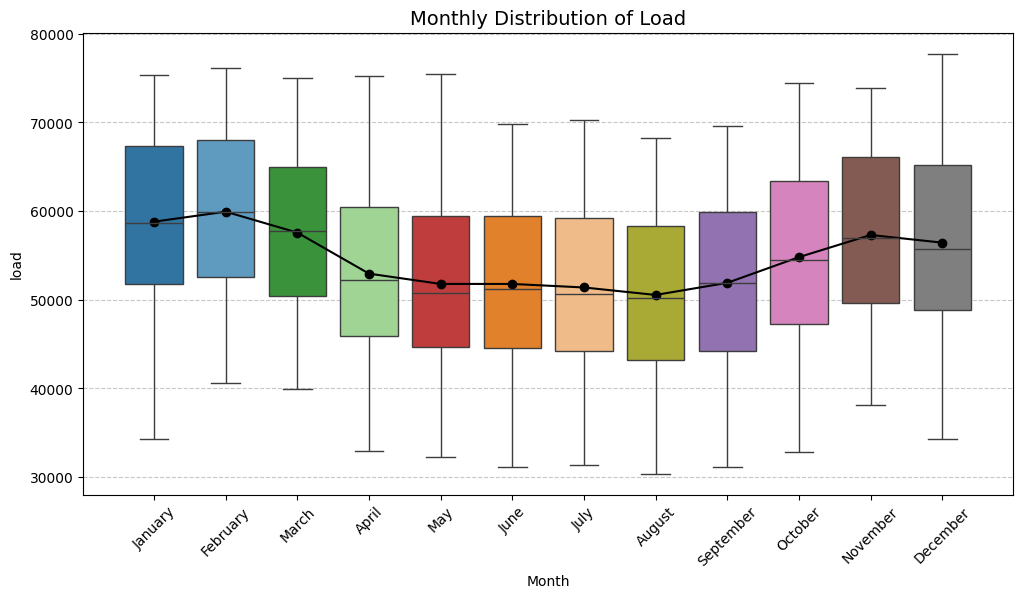

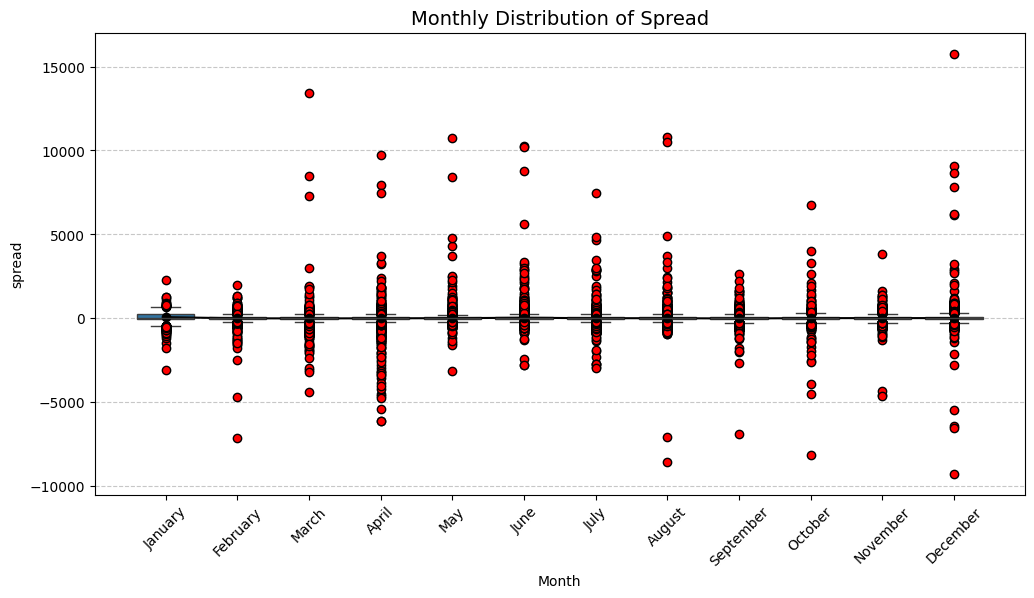

In [410]:
def plot_monthly_boxplots(df, columns):
    """
    Plots boxplots for the monthly distribution of selected variables with rainbow colors.
    
    Args:
        df (pd.DataFrame): The input time-series dataframe with a DatetimeIndex.
        columns (list): List of column names to create boxplots for.
        ylabel (str): Label for the y-axis.
        title_prefix (str): Prefix for the plot title (e.g., "Monthly Distribution of").
    """
    df['Month'] = df.index.month_name()
    monthly_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                     'July', 'August', 'September', 'October', 'November', 'December']

    seasonal_colors = {
        "January": "#1f77b4", "February": "#4f9dcf", "March": "#2ca02c",
        "April": "#98df8a", "May": "#d62728", "June": "#ff7f0e",
        "July": "#ffbb78", "August": "#bcbd22", "September": "#9467bd",
        "October": "#e377c2", "November": "#8c564b", "December": "#7f7f7f"
    }

    for column in columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=df, x="Month", hue="Month", y=column, order=monthly_order, legend=False, 
            palette=seasonal_colors, flierprops={'markerfacecolor': 'red', 'markeredgecolor': 'black'}
        )
        
        # Overlay monthly means
        monthly_means = df.groupby("Month")[column].mean().reindex(monthly_order)
        plt.plot(range(len(monthly_means)), monthly_means, marker='o', color='black', label="Monthly Mean")
        plt.title(f"Monthly Distribution of {column.capitalize()}", fontsize=14)
        plt.xlabel("Month")
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.xticks(rotation=45)
        plt.show()

plot_monthly_boxplots(df, columns=["wind", "solar", "load", "spread"])

- Here we can clearly see the trend of wind whihc tend to be the lowets in summer, however due to the chaotic natur eof wind, many outliers are observed during this period. We also see a mean value (the dark point) being relatively close to the median value( the horizontal abr of teh box) which

- For solar forecasts distribution does not display any outliers in the spring and summer, however durign fall and winter many outliers are observed. In addition, the median is very high comapred to the median, potentially indicating highly skewed distribution.

- Load forecasts does not showcase any outlier and the mean is very close to teh median, and across the seasosn we observe slightly different trends where there is a slightly higher demand observed during fall and winter where electricty demand rises probably due to cold temperatures.

- Most of the spread's distribution is near 0 with a box that it not even visible, however many outleirs are observed.

## **Data Processing**

### **Data Transformation & Outlier Handling**

### **Log Transformation**

array([[<Axes: title={'center': 'wind'}>,
        <Axes: title={'center': 'solar'}>],
       [<Axes: title={'center': 'load'}>, <Axes: >]], dtype=object)

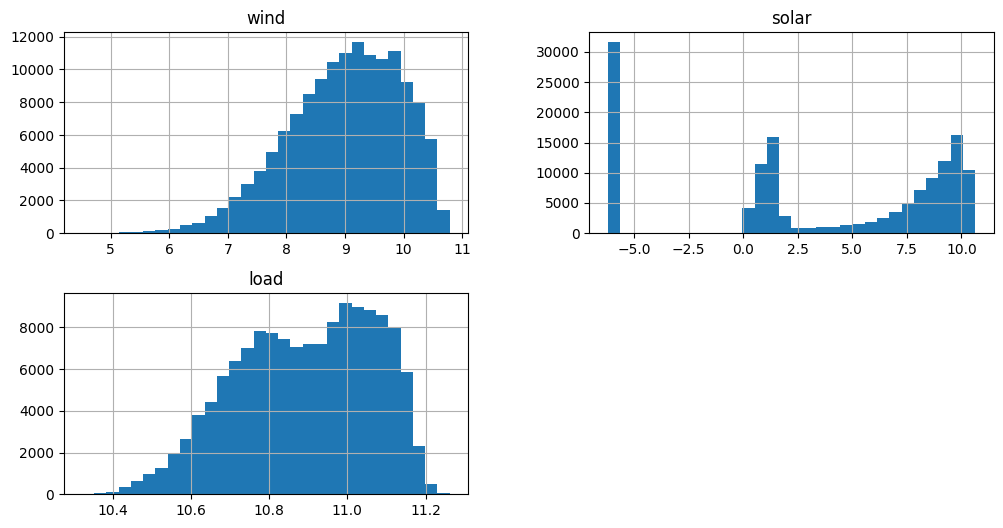

In [393]:
# Log transformaiton only for posiitve data so add a small value for solar
regressors = ["wind", "solar", "load"]

log_transforms = df[regressors].apply(lambda x: np.log(x+1e-3))
log_transforms.hist(figsize=(12, 6), bins=30)

The log transformation for wind and load is reasolably good despite observing a slight skewness on the left, howveer for solar it is not performing well, thus we must investigate othe rtrasnfromations whihc could be more appropriate.

### **Square Root Transformation**

array([[<Axes: title={'center': 'wind'}>,
        <Axes: title={'center': 'solar'}>],
       [<Axes: title={'center': 'load'}>, <Axes: >]], dtype=object)

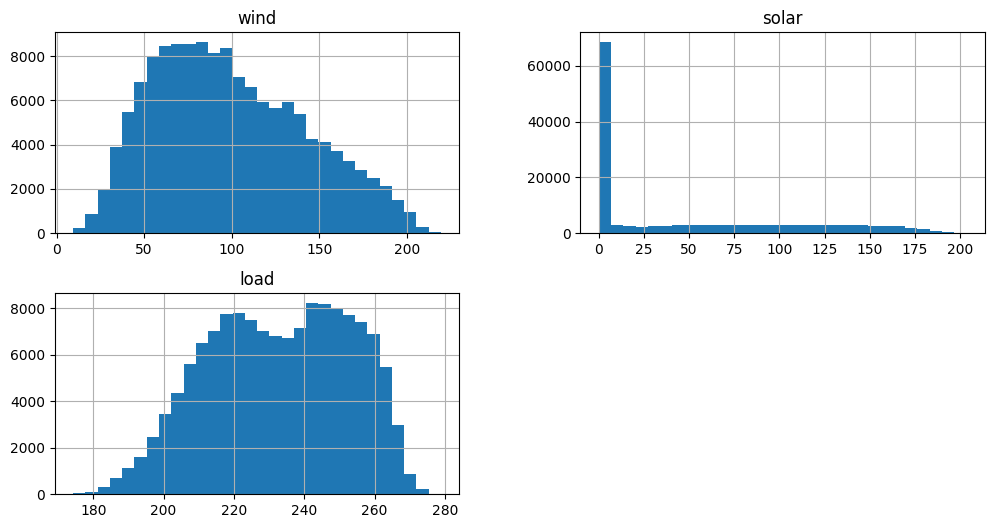

In [392]:
sqrt_transforms = df[regressors].apply(lambda x: np.sqrt(x))
sqrt_transforms.hist(figsize=(12, 6), bins=30)

Now the distribution is sloightly right skew for wind and left skewed for load, however for solar, the square root reduces the amplitude of the solar power forecatss but it is still not normal.

### **Inverse Transformation**

array([[<Axes: title={'center': 'wind'}>,
        <Axes: title={'center': 'solar'}>],
       [<Axes: title={'center': 'load'}>, <Axes: >]], dtype=object)

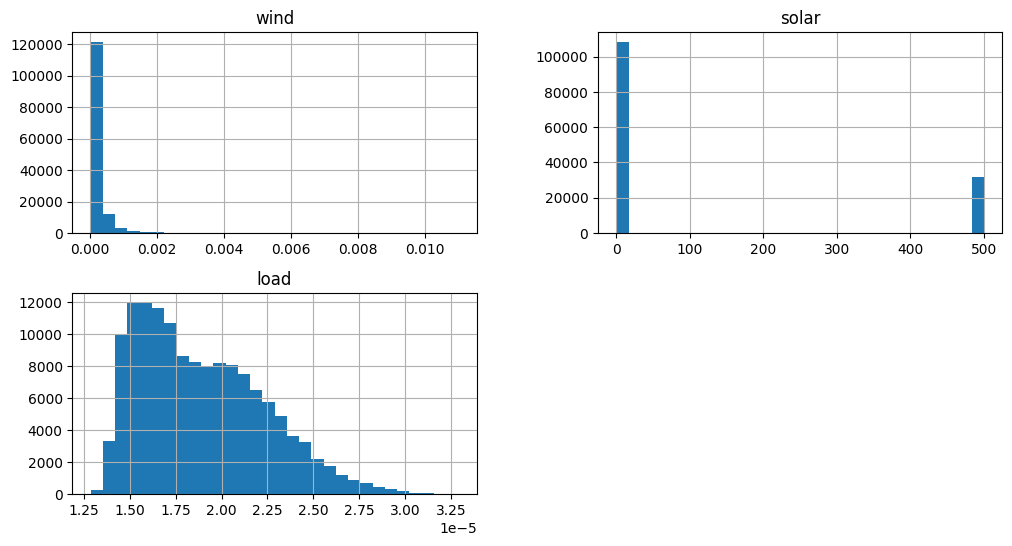

In [391]:
inv_transforms = df[regressors].apply(lambda x: 1/(x+1e-3))
inv_transforms.hist(figsize=(12, 6), bins=30)

Inverse transformation works relatively bad for wind and solar, however not significanlty bad for load. However, more trasnformation are possible where instad of the natural log we could sue the 10 base log or any base, the same with the square root we could try the cubic root or the n-th root.

### **Box-Cox Transformation**

The Box-Cox transformation is a widely used technique for normalizing data to meet the assumptions of statistical models. It applies a power transformation controlled by a parameter, lambda ($\lambda$). The value of $\lambda$ determines the type of transformation applied: 

- When $\lambda = 0$, the transformation is logarithmic.
- For $\lambda \neq 0$, it applies a power transformation that can range from square root to inverse transformations.

This flexibility makes Box-Cox particularly effective for handling skewed data and stabilizing variance. The formula for the transformation is:

$$
y(\lambda) = 
\begin{cases} 
\frac{y^\lambda - 1}{\lambda}, & \text{if } \lambda \neq 0 \\
\ln(y), & \text{if } \lambda = 0
\end{cases}
$$

Where:
- $y$ is the original data (must be positive).
- $\lambda$ is the transformation parameter.

This transformation ensures that the data becomes closer to a normal distribution, improving the performance of statistical and machine learning models.

Box-Cox Lambdas: {'wind': np.float64(0.23877356336940433), 'solar': np.float64(0.06161073690207068), 'load': np.float64(0.9313627656667828)}


array([[<Axes: title={'center': 'wind'}>,
        <Axes: title={'center': 'solar'}>],
       [<Axes: title={'center': 'load'}>, <Axes: >]], dtype=object)

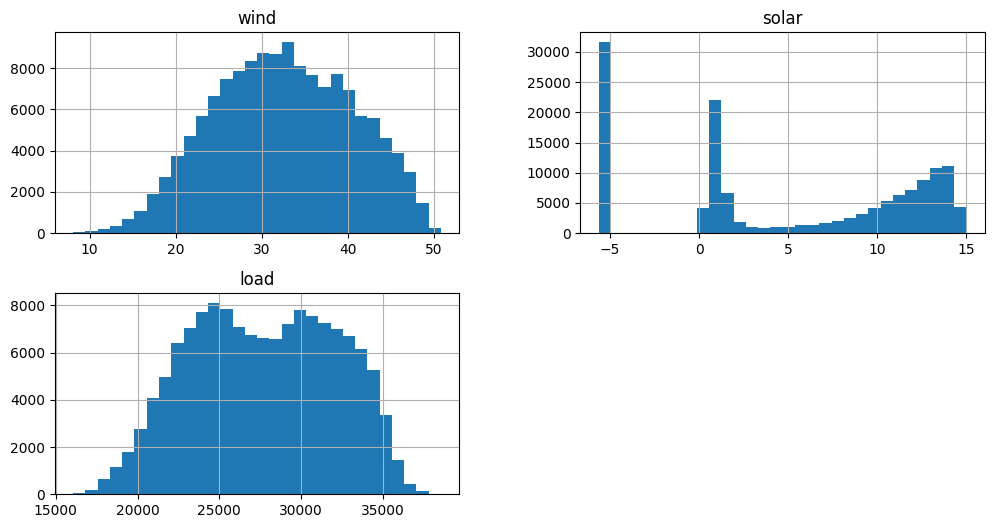

In [390]:
from scipy.stats import boxcox

def apply_boxcox(df, columns):
    """
    Apply Box-Cox transformation to specified columns in a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        columns (list): List of column names to apply Box-Cox transformation.
        
    Returns:
        pd.DataFrame: DataFrame with transformed columns and Box-Cox lambdas.
    """
    box_cox_transform = pd.DataFrame(index=df.index, columns=columns)
    boxcox_lambdas = {}

    for col in columns:
        transformed_col = df[col]
        if (df[col] <= 0).any():
            transformed_col += 1e-3

        box_cox_transform[col], boxcox_lambdas[col] = boxcox(transformed_col)
    
    return box_cox_transform, boxcox_lambdas

transformed_df, boxcox_lambdas = apply_boxcox(df, regressors)
print("Box-Cox Lambdas:", boxcox_lambdas)

transformed_df.hist(figsize=(12, 6), bins=30)

- **Wind Power Forecast**: The Box-Cox transformation effectively reduces the skewness compared to logarithmic or square root transformations. The resulting lambda value of approximately **0.25** indicates that a quadratic root transformation has been applied, significantly improving the symmetry of the distribution.

- **Load Forecast**: The transformation achieves a moderate reduction in skewness. With a lambda value of **0.93**, the adjustment is minimal, as a lambda of 1 implies no transformation. This reflects that the original distribution was already relatively symmetrical.

- **Solar Power Forecast**: The Box-Cox transformation is less effective for solar data, resulting in a left-skewed distribution. The lambda value of **0.06** corresponds to a 15th root transformation ($1/15 \approx 0.067$), which highlights the difficulty of achieving symmetry due to the unique characteristics of the data, such as the large number of zero values during nighttime hours.

### **Winsorization**

The spread data exhibits extreme values that can distort the distribution and negatively impact the analysis. Winsorization is an effective technique to handle such outliers by capping the extreme values to a specific percentile. 

This approach ensures that the impact of outliers is mitigated without entirely removing them, preserving the overall structure of the data while reducing skewness and kurtosis. Winsorization is particularly useful when the spread's extreme values are suspected to arise from rare but plausible events rather than errors.

Kurtosis: 1.8540087531622316
Skewness: -0.27600462615011034


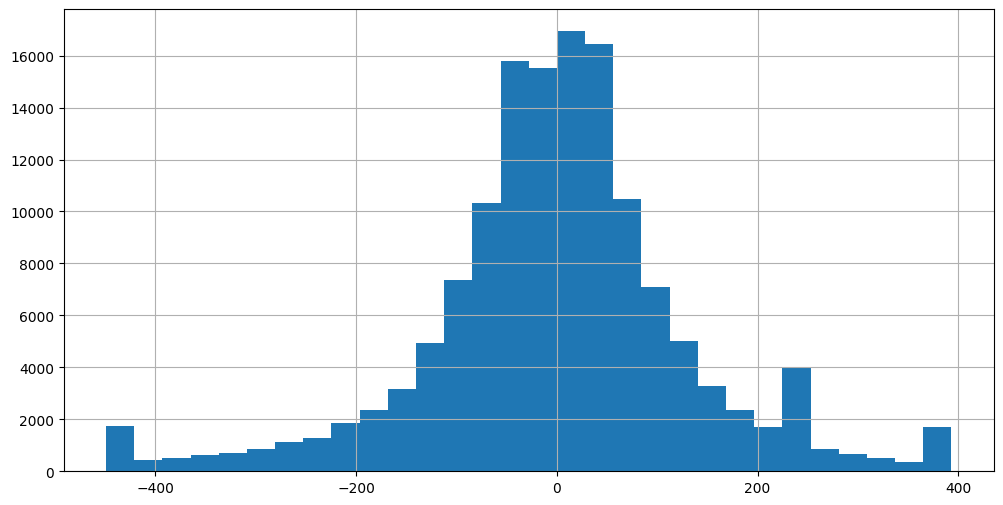

In [389]:
spread_winsorized = winsorize(df["spread"], limits=[0.01, 0.01])
df["spread_winsorized"] = spread_winsorized
df["spread_winsorized"].hist(figsize=(12, 6), bins=30)
print("Kurtosis:", kurtosis(df["spread_winsorized"]))
print("Skewness:", skew(df["spread_winsorized"]))

By just applyign a winzorization on the 1% and 99% quantiles, we obtain a much better distribution which looks normal with a close to 0 skewness and close to 3 kurtosis.

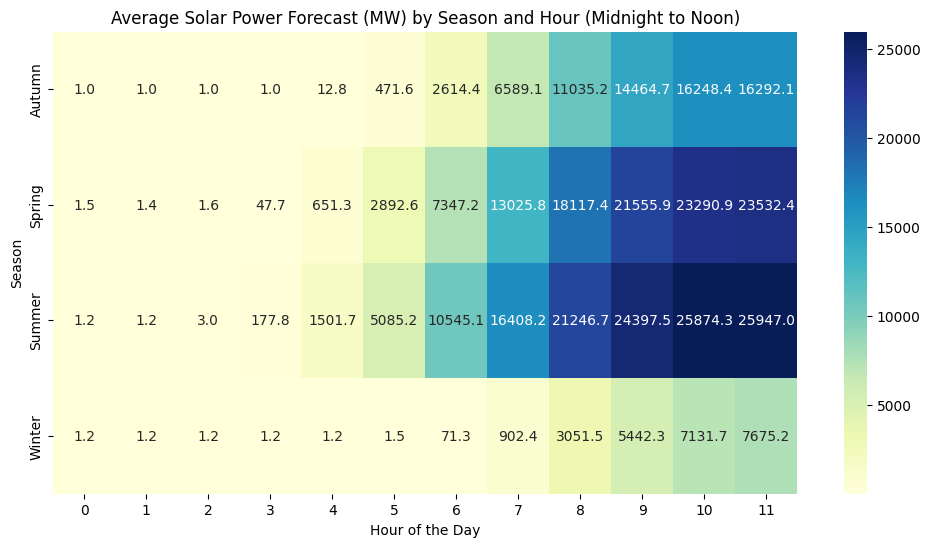

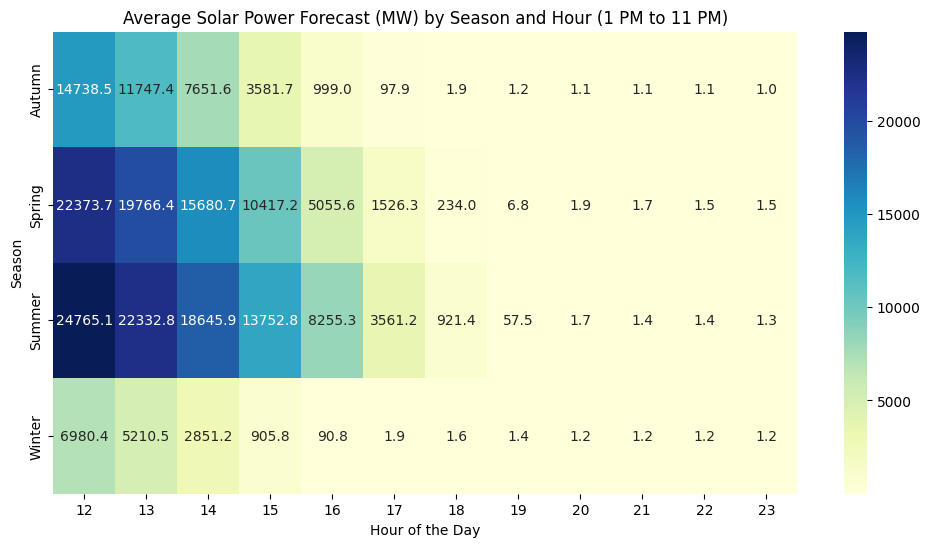

In [426]:
# Add a 'Season' column based on the date
def get_season(date):
    if date.month in [12, 1, 2]:
        return "Winter"
    elif date.month in [3, 4, 5]:
        return "Spring"
    elif date.month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df["Season"] = df.index.map(get_season)

# Add an 'Hour' column
df["Hour"] = df.index.hour

# Create the pivot table
pivot_table = df.pivot_table(
    values="solar", 
    index="Season", 
    columns="Hour", 
    aggfunc="mean"
)

# Display the pivot table
#print(pivot_table)

# Split into two parts: midnight to noon and 1 PM to 11 PM
pivot_table_am = pivot_table.loc[:, :11]
pivot_table_pm = pivot_table.loc[:, 12:23]

# Plotting AM hours (Midnight to Noon)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table_am, cmap="YlGnBu", annot=True, fmt=".1f", cbar=True)
plt.title("Average Solar Power Forecast (MW) by Season and Hour (Midnight to Noon)")
plt.xlabel("Hour of the Day")
plt.ylabel("Season")
plt.show()

# Plotting PM hours (1 PM to 11 PM)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table_pm, cmap="YlGnBu", annot=True, fmt=".1f", cbar=True)
plt.title("Average Solar Power Forecast (MW) by Season and Hour (1 PM to 11 PM)")
plt.xlabel("Hour of the Day")
plt.ylabel("Season")
plt.show()

## **Feature Engineering**

In [ ]:
z_scores = df.apply(lambda x: zscore(x), axis=0)
outliers = (z_scores.abs() > 3).any(axis=1)
df["outlier_flag_zscore"] = outliers
df[df["outlier_flag_zscore"] == True]

Outliers:


,wind,solar,load,spread,outlier_flag_zscore
Date,,,,,
2020-02-09 09:30:00,30983.0,12445.0,57029.0,-1343.70,True
2020-02-19 16:30:00,27600.0,96.0,69272.0,-1567.32,True
2020-02-22 16:30:00,40423.0,58.0,59137.0,-22.56,True
2020-02-22 16:45:00,40694.0,15.0,60251.0,73.91,True
2020-02-22 17:00:00,40517.0,0.0,62022.0,-46.82,True
...,...,...,...,...,...
2023-12-29 13:45:00,41288.0,2362.0,59218.0,-51.91,True
2023-12-29 14:00:00,41138.0,1813.0,59275.0,-18.11,True
2023-12-29 14:15:00,40398.0,1288.0,58856.0,-37.24,True


The Z-Score method for detecting outliers may give misflag observations as outliers since it assumes that the distribution is normal, whihc is clearly not the same for wind and solar power forecasts which are right-skewed.